In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import linear_regression
import datetime
import random
import tslearn
import scipy
from numpy.polynomial.polynomial import polyfit
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn import linear_model
random.seed(0)

In [2]:
#from print_versions import print_versions
import sys

#print(sys. version)
#print_versions(globals())

# Utilities

In [10]:
def computeSlopes(df):
    slopes = []
    for index, row in df.iterrows():
        y = np.array(row)
        x = np.arange(0, y.size)
        X = np.column_stack([np.ones_like(x), x])
        coef, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
        slope = coef[1]
        slopes.append(slope)
    return slopes

In [4]:
def decisionTree(ndim, X_train, X_test, y_train, y_test):
    clf = DecisionTreeClassifier()
    clf = clf.fit(X_train.reshape(-1, ndim),y_train)
    y_pred = clf.predict(X_test.reshape(-1, ndim))
    print("Decision Tree Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("Decision Tree Precision:", metrics.precision_score(y_test, y_pred, average='macro'))
    print("Decision Tree Recall:", metrics.recall_score(y_test, y_pred, average='macro'))
    print("Decision Tree F1:", metrics.f1_score(y_test, y_pred, average='macro'))

In [5]:
def randomForest(ndim, X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier()
    clf = clf.fit(X_train.reshape(-1, ndim),y_train)
    y_pred = clf.predict(X_test.reshape(-1, ndim))
    print("Random Forest Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("Random Forest Precision:", metrics.precision_score(y_test, y_pred, average='macro'))
    print("Random Forest Recall:", metrics.recall_score(y_test, y_pred, average='macro'))
    print("Random Forest F1:", metrics.f1_score(y_test, y_pred, average='macro'))

In [6]:
def randomForest2(ndim, X_train, X_test, y_train, y_test, filename):
    train_loss = []
    val_loss = []
    n_estimators_list = range(1, 51)  # simulate "epochs" via number of trees

    for n in n_estimators_list:
        clf = RandomForestClassifier(n_estimators=n, random_state=42, warm_start=True)
        clf.fit(X_train.reshape(-1, ndim), y_train)
        y_pred_train = clf.predict(X_train.reshape(-1, ndim))
        y_pred_val = clf.predict(X_test.reshape(-1, ndim))

        # 1 - accuracy ≈ "loss"
        train_loss.append(1 - metrics.accuracy_score(y_train, y_pred_train))
        val_loss.append(1 - metrics.accuracy_score(y_test, y_pred_val))

    # Final model metrics
    print("Random Forest Accuracy:", metrics.accuracy_score(y_test, y_pred_val))
    print("Random Forest Precision:", metrics.precision_score(y_test, y_pred_val, average='macro'))
    print("Random Forest Recall:", metrics.recall_score(y_test, y_pred_val, average='macro'))
    print("Random Forest F1:", metrics.f1_score(y_test, y_pred_val, average='macro'))

    # Plot training vs validation loss
    plt.plot(n_estimators_list, train_loss, label='Train Loss', color='skyblue')
    plt.plot(n_estimators_list, val_loss, label='Validation Loss', color='salmon')
    plt.xlabel('Number of Trees (Estimators)')
    plt.ylabel('Loss (1 - Accuracy)')
    plt.title('Random Forest Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

In [7]:
def randomForest3(ndim, X_train, X_test, y_train, y_test, cv=5, scoring='accuracy', filename="null"):
    clf = RandomForestClassifier()
    clf = clf.fit(X_train.reshape(-1, ndim), y_train)
    y_pred = clf.predict(X_test.reshape(-1, ndim))

    print("Random Forest Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("Random Forest Precision:", metrics.precision_score(y_test, y_pred, average='macro'))
    print("Random Forest Recall:", metrics.recall_score(y_test, y_pred, average='macro'))
    print("Random Forest F1:", metrics.f1_score(y_test, y_pred, average='macro'))

    # --- added: learning curve (train vs validation accuracy) ---
    Xtr = X_train.reshape(-1, ndim)
    train_sizes, train_scores, val_scores = learning_curve(
        RandomForestClassifier(n_estimators=clf.n_estimators, random_state=42),
        Xtr, y_train,
        cv=cv, scoring=scoring, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 8), shuffle=True, random_state=42
    )

    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure()
    plt.plot(train_sizes, train_mean, 'o-', label='Train Accuracy')
    plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title('Random Forest Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

# Bank Reserves

In [11]:
br_poor = pd.read_csv("~/Desktop/TS-Clustering/SimData/bank_reserves_outputs_poor.csv", header=None)
br_middle = pd.read_csv("~/Desktop/TS-Clustering/SimData/bank_reserves_outputs_middle.csv", header=None)
br_rich = pd.read_csv("~/Desktop/TS-Clustering/SimData/bank_reserves_outputs_rich.csv", header=None)
br_inputs = pd.read_csv("~/Desktop/TS-Clustering/SimData/bank_reserves_inputs.csv", header=None)
br_inputs_arr = br_inputs.iloc[:, 0].to_numpy()

In [18]:
slopes_poor = computeSlopes(br_poor)

In [19]:
slopes_middle = computeSlopes(br_middle)

In [20]:
slopes_rich = computeSlopes(br_rich)

In [38]:
X = np.array(br_inputs_arr).reshape(-1, 1)
y = np.array(slopes_poor).reshape(-1, 1)
reg = linear_model.LinearRegression().fit(X, y)
reg.score(X, y)

0.9039877634820104

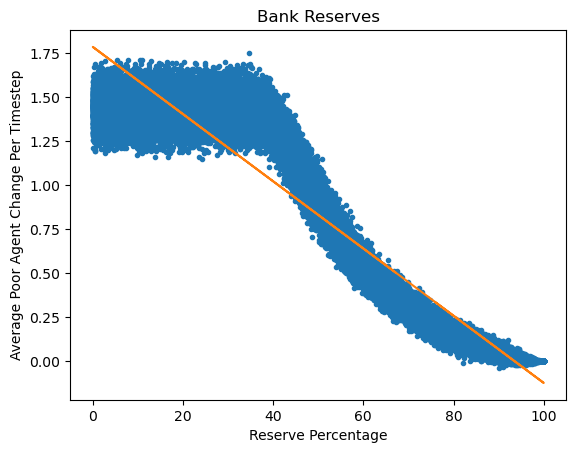

In [39]:
plt.plot(br_inputs_arr, slopes_poor, '.')
plt.plot(br_inputs_arr, reg.intercept_[0] + reg.coef_[0][0] * br_inputs_arr, '-')
plt.xlabel("Reserve Percentage")
plt.ylabel("Average Poor Agent Change Per Timestep")
plt.title("Bank Reserves")
plt.savefig('bank_reserve_slope.png')
plt.show()

In [41]:
X = np.array(br_inputs_arr).reshape(-1, 1)
y = np.array(slopes_middle).reshape(-1, 1)
reg = linear_model.LinearRegression().fit(X, y)
reg.score(X, y)

0.8988972462866229

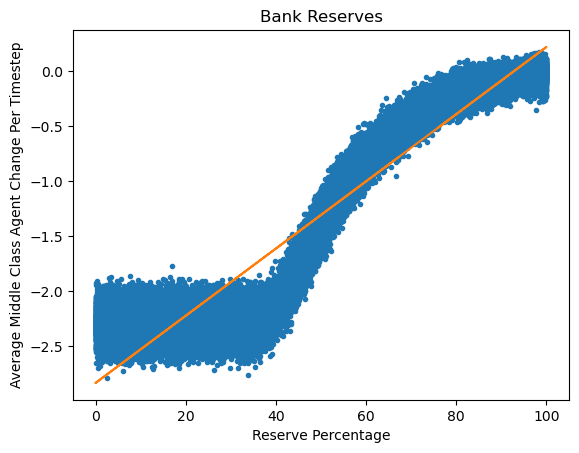

In [43]:
plt.plot(br_inputs_arr, slopes_middle, '.')
plt.plot(br_inputs_arr, reg.intercept_[0] + reg.coef_[0][0] * br_inputs_arr, '-')
plt.xlabel("Reserve Percentage")
plt.ylabel("Average Middle Class Agent Change Per Timestep")
plt.title("Bank Reserves")
plt.savefig('bank_reserve_slope_middle.png')
plt.show()

In [44]:
X = np.array(br_inputs_arr).reshape(-1, 1)
y = np.array(slopes_rich).reshape(-1, 1)
reg = linear_model.LinearRegression().fit(X, y)
reg.score(X, y)

0.8607613944321865

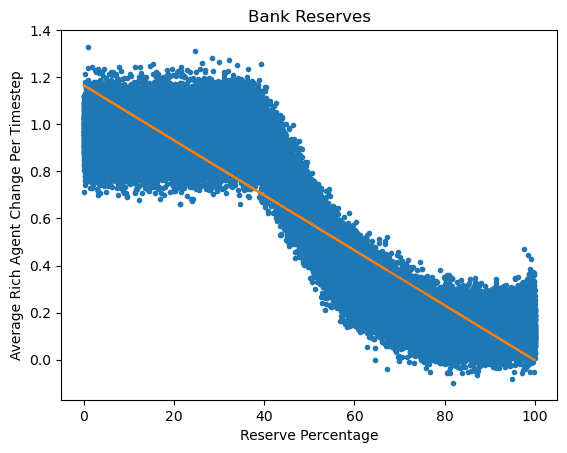

In [45]:
plt.plot(br_inputs_arr, slopes_rich, '.')
plt.plot(br_inputs_arr, reg.intercept_[0] + reg.coef_[0][0] * br_inputs_arr, '-')
plt.xlabel("Reserve Percentage")
plt.ylabel("Average Rich Agent Change Per Timestep")
plt.title("Bank Reserves")
plt.savefig('bank_reserve_slope_rich.png')
plt.show()

In [51]:
q1, q2, q3 = np.quantile(slopes_poor, [0.25, 0.50, 0.75])
inputs_class = []
for val in slopes_poor:
    if val < q1:
        inputs_class.append("Q1")
    elif val < q2:
        inputs_class.append("Q2")
    elif val < q3:
        inputs_class.append("Q3")
    else:
        inputs_class.append("Q4")

In [52]:
X_train, X_test, y_train, y_test = train_test_split(br_inputs_arr, inputs_class, test_size=0.2, random_state=1) 

In [53]:
decisionTree(1, X_train, X_test, y_train, y_test)

Decision Tree Accuracy: 0.76905
Decision Tree Precision: 0.7690359751904423
Decision Tree Recall: 0.7691082676861667
Decision Tree F1: 0.7690658921682513


In [54]:
randomForest(1, X_train, X_test, y_train, y_test)

Random Forest Accuracy: 0.7691
Random Forest Precision: 0.7691006568596235
Random Forest Recall: 0.7691574734540964
Random Forest F1: 0.7691222981408533


Random Forest Accuracy: 0.7693
Random Forest Precision: 0.7692151333502155
Random Forest Recall: 0.7693658558122352
Random Forest F1: 0.7692799024274785


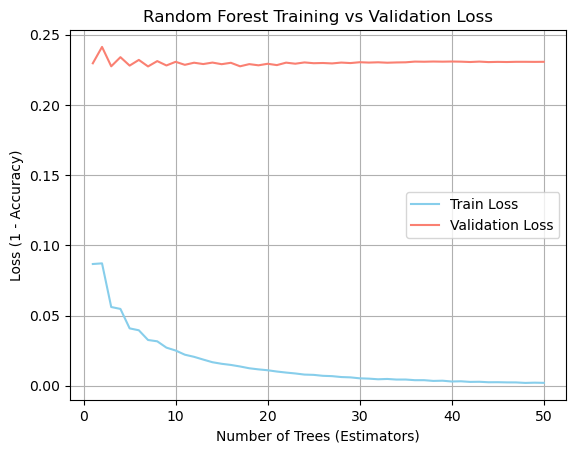

In [55]:
randomForest2(1, X_train, X_test, y_train, y_test, "br_rf_training_n_trees.png")
#plt.savefig("br_rf_training_n_trees.png", format="png")

Random Forest Accuracy: 0.7691
Random Forest Precision: 0.7690823579670055
Random Forest Recall: 0.7691605582770195
Random Forest F1: 0.7691146309309722


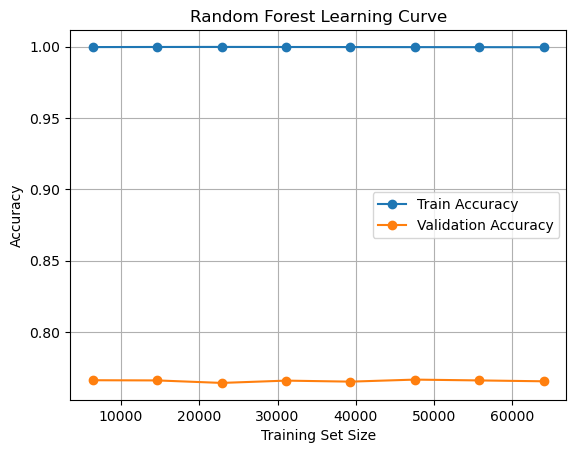

In [56]:
from sklearn.model_selection import learning_curve
randomForest3(1, X_train, X_test, y_train, y_test, 5, "accuracy", "br_rf_training_train_size.png")
#plt.savefig("br_rf_training_train_size.png", format="png")

# Epstein Civil Violence

In [58]:
ecv_active = pd.read_csv("~/Desktop/TS-Clustering/SimData/epsteinCV_outputs_active.csv", header=None)
ecv_jailed = pd.read_csv("~/Desktop/TS-Clustering/SimData/epsteinCV_outputs_jailed.csv", header=None)
ecv_quiet = pd.read_csv("~/Desktop/TS-Clustering/SimData/epsteinCV_outputs_quiet.csv", header=None)
ecv_inputs = pd.read_csv("~/Desktop/TS-Clustering/SimData/epsteinCV_inputs.csv", header=None, sep=" ")
br_inputs_arr = ecv_inputs.to_numpy()

In [61]:
slopes_active = computeSlopes(ecv_active)

In [62]:
slopes_jailed = computeSlopes(ecv_jailed)

In [63]:
slopes_quiet = computeSlopes(ecv_quiet)

In [29]:
reg = linear_model.LinearRegression().fit(br_inputs_arr.reshape(-1, 3), slopes_active.reshape(-1, 1))
reg.score(br_inputs_arr.reshape(-1, 3), slopes_scipy.reshape(-1, 1))

0.30103337875167113

In [30]:
import statsmodels.api as sm

X = sm.add_constant(br_inputs_arr)  # add intercept term
model = sm.OLS(slopes_scipy, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     7229.
Date:                Mon, 03 Nov 2025   Prob (F-statistic):               0.00
Time:                        13:14:05   Log-Likelihood:                -94930.
No. Observations:               50362   AIC:                         1.899e+05
Df Residuals:                   50358   BIC:                         1.899e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1450      0.058    -19.588      0.0

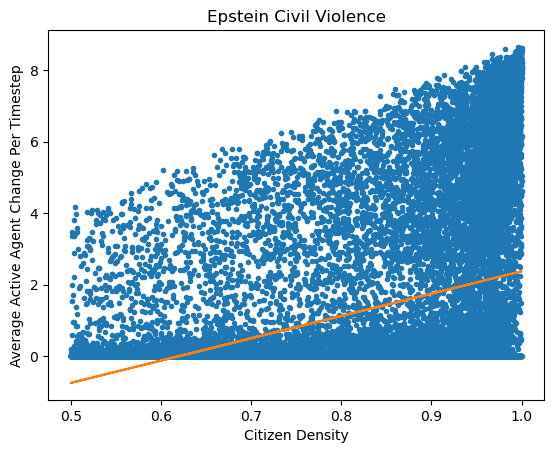

In [31]:
b, m = polyfit(br_inputs_arr[:,0], slopes_scipy, 1)

plt.plot(br_inputs_arr[:,0], slopes_scipy, '.')
plt.plot(br_inputs_arr[:,0], b + m * br_inputs_arr[:,0], '-')
plt.xlabel("Citizen Density")
plt.ylabel("Average Active Agent Change Per Timestep")
plt.title("Epstein Civil Violence")
plt.savefig('ecv_citdens_slope.png')
plt.show()

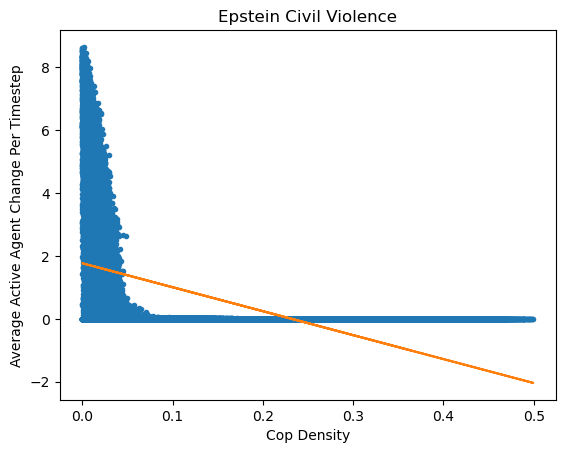

In [32]:
b, m = polyfit(br_inputs_arr[:,1], slopes_scipy, 1)

plt.plot(br_inputs_arr[:,1], slopes_scipy, '.')
plt.plot(br_inputs_arr[:,1], b + m * br_inputs_arr[:,1], '-')
plt.xlabel("Cop Density")
plt.ylabel("Average Active Agent Change Per Timestep")
plt.title("Epstein Civil Violence")
plt.savefig('ecv_copdens_slope.png')
plt.show()

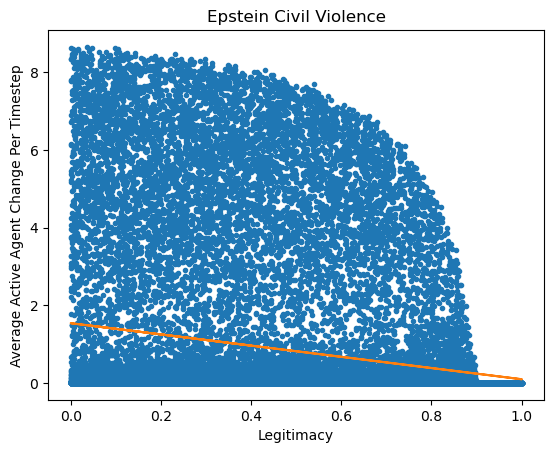

In [33]:
b, m = polyfit(br_inputs_arr[:,2], slopes_scipy, 1)

plt.plot(br_inputs_arr[:,2], slopes_scipy, '.')
plt.plot(br_inputs_arr[:,2], b + m * br_inputs_arr[:,2], '-')
plt.xlabel("Legitimacy")
plt.ylabel("Average Active Agent Change Per Timestep")
plt.title("Epstein Civil Violence")
plt.savefig('ecv_legit_slope.png')
plt.show()

In [34]:
inputs_class = []
for val in slopes_scipy:
    if val < 2:
        inputs_class.append("Q1")
    elif val >= 2 and val < 4:
        inputs_class.append("Q2")
    elif val >= 4 and val < 6:
        inputs_class.append("Q3")
    else:
        inputs_class.append("Q4")

In [35]:
X_train, X_test, y_train, y_test = train_test_split(br_inputs_arr, inputs_class, test_size=0.2, random_state=1) 

In [36]:
decisionTree(3, X_train, X_test, y_train, y_test)

Decision Tree Accuracy: 0.9482775737119031
Decision Tree Precision: 0.7826793885600682
Decision Tree Recall: 0.7742120340608921
Decision Tree F1: 0.7783673421525619


In [37]:
randomForest(3, X_train, X_test, y_train, y_test)

Random Forest Accuracy: 0.9613819120420927
Random Forest Precision: 0.8413062159021389
Random Forest Recall: 0.8295204015638337
Random Forest F1: 0.8349006518082598


Random Forest Accuracy: 0.9600913332671498
Random Forest Precision: 0.8374599683483815
Random Forest Recall: 0.826771263318565
Random Forest F1: 0.831785299867318


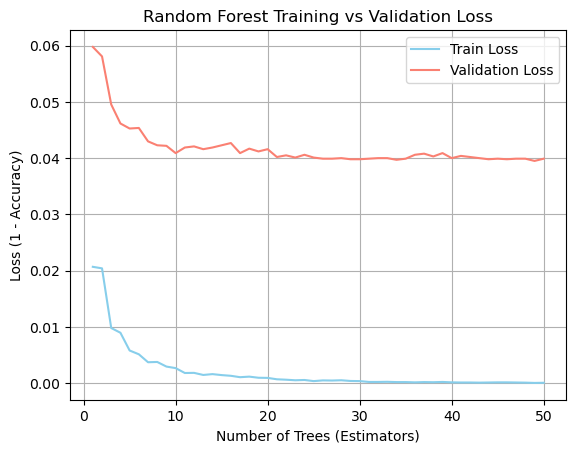

In [38]:
randomForest2(3, X_train, X_test, y_train, y_test, "ecv_rf_training_n_trees.png")
#plt.savefig("ecv_rf_training_n_trees.png", format="png")

Random Forest Accuracy: 0.9596942321056289
Random Forest Precision: 0.8349025099549419
Random Forest Recall: 0.8239184296753141
Random Forest F1: 0.8288153376450875


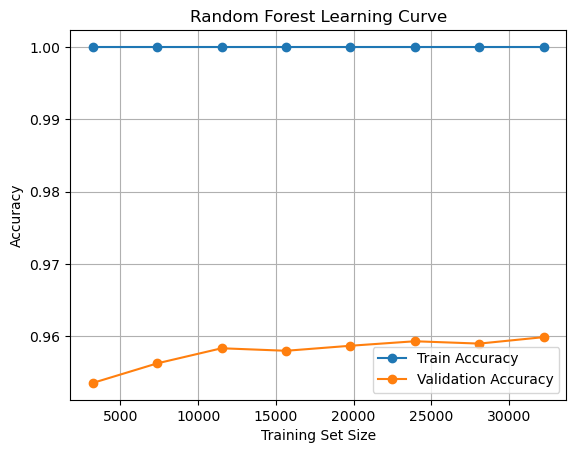

In [39]:
randomForest3(3, X_train, X_test, y_train, y_test, 5, "accuracy", "ecv_rf_training_train_size.png")
#plt.savefig("ecv_rf_training_train_size.png", format="png")

# Forest Fire

In [40]:
def import_ff_data(filename):
    expected_columns=155
    data = []
    with open(filename, 'r') as file:
        for line in file:
            row = line.strip().split(',')
            if len(row) < expected_columns:
                row += [np.nan] * (expected_columns - len(row))
            data.append(row)
    df = pd.DataFrame(data)
    def fill_last_valid(row):
        for i in range(1, len(row)):
            if pd.isna(row[i]):
                row[i] = row[i - 1]  
        return row
    df_filled = df.apply(fill_last_valid, axis=1)
    return df_filled

In [41]:
ff_onfire = import_ff_data("C:/Users/met48/Desktop/TS-Clustering/SimData/forest_fire_outputs_onfire.csv")
ff_fine = import_ff_data("C:/Users/met48/Desktop/TS-Clustering/SimData/forest_fire_outputs_fine.csv")
ff_burned = import_ff_data("C:/Users/met48/Desktop/TS-Clustering/SimData/forest_fire_outputs_burned.csv")

In [42]:
ff_inputs = pd.read_csv("~/Desktop/TS-Clustering/SimData/forest_fire_inputs.csv", header=None, sep=" ")
br_inputs_arr = ff_inputs.iloc[:, 0].to_numpy()

In [43]:
slopes_scipy = computeSlopes(ff_burned.astype('float'))

C:\Users\met48\AppData\Local\Temp\ipykernel_30160\3395282983.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a, _, _, _ = np.linalg.lstsq(x, y)


In [44]:
reg = linear_model.LinearRegression().fit(br_inputs_arr.reshape(-1, 1), slopes_scipy.reshape(-1, 1))
reg.score(br_inputs_arr.reshape(-1, 1), slopes_scipy.reshape(-1, 1))

0.9392440237205283

In [45]:
scipy.stats.pearsonr(br_inputs_arr, slopes_scipy)

PearsonRResult(statistic=0.9691460280682827, pvalue=0.0)

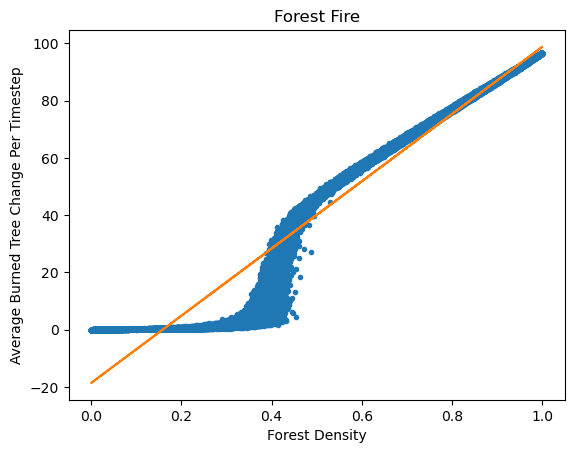

In [46]:
b, m = polyfit(br_inputs_arr, slopes_scipy, 1)

plt.plot(br_inputs_arr, slopes_scipy, '.')
plt.plot(br_inputs_arr, b + m * br_inputs_arr, '-')
plt.xlabel("Forest Density")
plt.ylabel("Average Burned Tree Change Per Timestep")
plt.title("Forest Fire")
plt.savefig('ff_density_slope.png')
plt.show()

In [47]:
inputs_class = []
for val in slopes_scipy:
    if val < 25:
        inputs_class.append("Q1")
    elif val >= 25 and val < 50:
        inputs_class.append("Q2")
    elif val >= 50 and val < 75:
        inputs_class.append("Q3")
    else:
        inputs_class.append("Q4")

In [48]:
X_train, X_test, y_train, y_test = train_test_split(br_inputs_arr, inputs_class, test_size=0.2, random_state=1) 

In [49]:
decisionTree(1, X_train, X_test, y_train, y_test)

Decision Tree Accuracy: 0.97695
Decision Tree Precision: 0.967063516656449
Decision Tree Recall: 0.9696143373301652
Decision Tree F1: 0.9683253537807396


In [50]:
randomForest(1, X_train, X_test, y_train, y_test)

Random Forest Accuracy: 0.977
Random Forest Precision: 0.967114020375532
Random Forest Recall: 0.9696714540767953
Random Forest F1: 0.968379101676716


Random Forest Accuracy: 0.97725
Random Forest Precision: 0.9674449373637327
Random Forest Recall: 0.9699637256634402
Random Forest F1: 0.9686909139435497


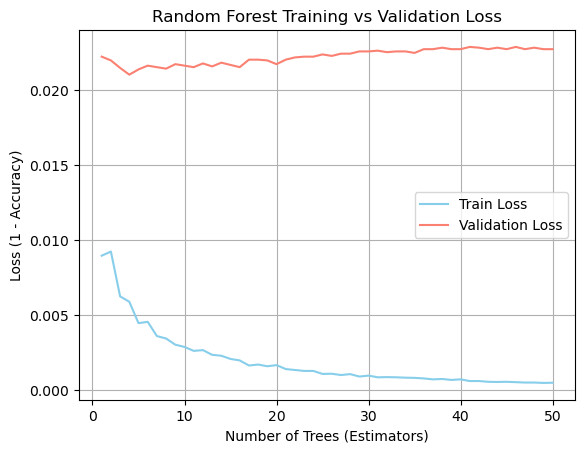

In [51]:
randomForest2(1, X_train, X_test, y_train, y_test, "ff_rf_training_n_trees.png")
#plt.savefig("ff_rf_training_n_trees.png", format="png")

Random Forest Accuracy: 0.977
Random Forest Precision: 0.967114020375532
Random Forest Recall: 0.9696714540767953
Random Forest F1: 0.968379101676716


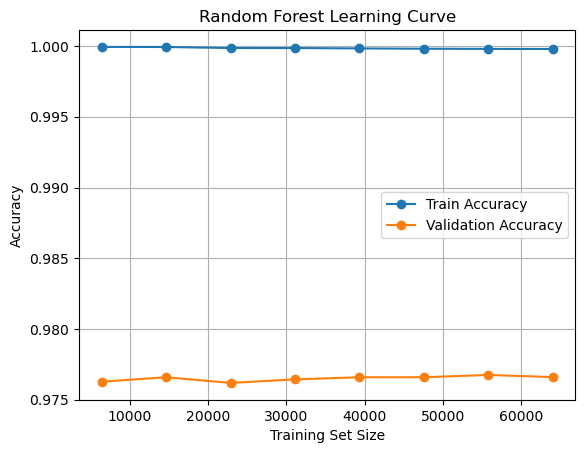

In [52]:
randomForest3(1, X_train, X_test, y_train, y_test, 5, "accuracy",         "ff_rf_training_train_size.png")
#plt.savefig("ff_rf_training_train_size.png", format="png")